In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc


import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from matplotlib.legend_handler import HandlerLine2D

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix , f1_score , accuracy_score , classification_report , log_loss
from sklearn.model_selection import cross_val_score



In [4]:
df = pd.read_csv('Preprocessed_02.csv', index_col='Customer_No')

In [5]:
df.head()

,N_Default_L3m,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,N_PosBkt_L3m,Ever_Default_L12M,Perc_Paymode_Online,Perc_Repay_Fail,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
Customer_No,,,,,,,,,,,,,,,
1,3,38,100.0,5,0.0,1,0.285714,0.428571,19.0,0.750,46,0,5527.0,15,0
2,1,68,100.0,1,0.0,1,0.000000,0.200000,2.0,0.500,33,0,12104.0,2,0
3,1,39,50.0,3,0.0,1,0.200000,0.200000,25.0,1.000,28,1,153179.0,8,0
4,0,76,100.0,0,0.0,0,0.000000,0.000000,0.0,0.500,26,2,181589.0,6,0
5,3,23,33.0,11,0.0,1,0.250000,0.250000,19.0,0.375,28,1,10661.0,8,0


In [8]:
X = df.drop('Target_Flag', axis = 1)
y = df['Target_Flag']

In [10]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [12]:
df.columns[:-1]

Index(['N_Default_L3m', 'Max_Utilization', 'Max_Perc_Def_Chg_Pending',
       'N_Family_Member', 'N_PosBkt_L3m', 'Ever_Default_L12M',
       'Perc_Paymode_Online', 'Perc_Repay_Fail', 'Max_DPD_L3m',
       'Perc_Paymode_Cheq_Fail', 'Age', 'N_Enq_L9m', 'Max_Loan_Balance_Others',
       'N_WorkEx_Yr'],
      dtype='object')

In [13]:
X = pd.DataFrame(X, columns=df.columns[:-1])

In [21]:
X_train,X_test, y_train,y_test = train_test_split(X,y)

In [26]:
def evaluate_model(model, class_balance, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Accuracy ({}): {:.2f}%".format(class_balance, model_acc * 100))
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred)
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [27]:
def get_roc_auc(y_test, predicted_proba):
    fpr, tpr, _ = roc_curve(y_test, predicted_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [28]:
models = []

class_weight = sum(y_train == 1)/sum(y_train == 0)
models.append(("XGBClassifier", XGBClassifier(objective = "binary:logistic" ,scale_pos_weight=class_weight,  random_state = 42)))

from collections import Counter
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = [total_samples / (class_counts[i] * len(class_counts)) for i in range(len(class_counts))]
models.append(("CatBoostClassifier", CatBoostClassifier(random_state = 42 , class_weights=class_weights, verbose = 0)))


models.append(("RandomForest", RandomForestClassifier(random_state = 42 , n_estimators = 200)))
models.append(("Extra Tree Classifier", ExtraTreesClassifier(random_state = 42 , n_estimators = 200)))
models.append(("Bagging Classifier", BaggingClassifier(random_state = 42 , n_estimators = 200)))
models.append(("Gradient Boosting Classifier" , GradientBoostingClassifier(random_state = 42)))
models.append(("LightGBM" , LGBMClassifier(random_state = 42 , n_estimators = 200)))
models.append(("Logistic Regression", LogisticRegression(random_state = 42 , solver = "liblinear")))
models.append(("KNeigbors", KNeighborsClassifier()))

In [29]:
def evaluation_metrics(model , X_train , y_train , X_test , y_test , params = False):
    
    mod = model[1].fit(X_train , y_train)
    preds = model[1].predict(X_test)
    accuracies = cross_val_score(estimator = model[1], X = X_train , y = y_train, cv = 5 , scoring = "f1")
    cm = confusion_matrix(y_test , preds)
    cf = classification_report(y_test , preds)
    f1 = 100 * (f1_score(y_test , preds))
    pred = model[1].predict_proba(X_test)
    score = log_loss(y_test , pred)
    
    
    print("\n")
    print(model[0])
    
    print("\n")
    if params:
        print(f"Best Parameters are : \n" , model[1].best_params_)
        print("\n")
        
    print(f"Confusion matrix : \n")
    plt.figure(figsize = (4 , 4))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.show()
    print("\n")
    
    print(f"Training score : {model[1].score(X_train , y_train):.4f}")
    print("\n") 
    
    print(f"Test Score : {model[1].score(X_test , y_test):.4f}")
    print("\n")
    
    print(f"K-fold accuracy : {np.mean(accuracies):.4f}")
    print("\n")
    
    print(f"Standard Deviation of Accuracies in k-fold : {np.std(accuracies):.4f}")
    print("\n")
    
    print(f"Classification report : \n\n{cf}")
    print("\n")
    
    print(f"F1 Score : {f1}")
    print("\n")
    
    print(f"Evaluation Score : {score}")
    print("\n")

    print("\n\n")
    
    sam = []
    sam.append(model[0])
    sam.append(model[1].score(X_train , y_train))
    sam.append(model[1].score(X_test , y_test))
    sam.append(np.mean(accuracies))
    sam.append(np.std(accuracies))
    sam.append(f1)
    sam.append(score)
    
    return sam , mod, get_roc_auc(y_test, pred[:,1])



XGBClassifier


Confusion matrix : 



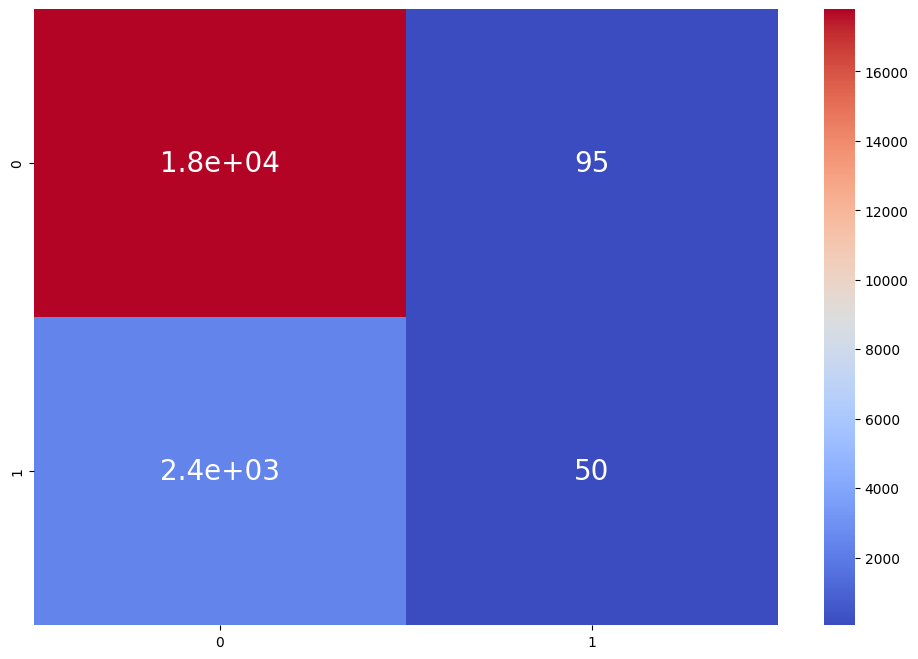



Training score : 0.8911


Test Score : 0.8783


K-fold accuracy : 0.0432


Standard Deviation of Accuracies in k-fold : 0.0073


Classification report : 

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     17883
           1       0.34      0.02      0.04      2427

    accuracy                           0.88     20310
   macro avg       0.61      0.51      0.49     20310
weighted avg       0.82      0.88      0.83     20310



F1 Score : 3.8880248833592534


Evaluation Score : 0.35222036550047586







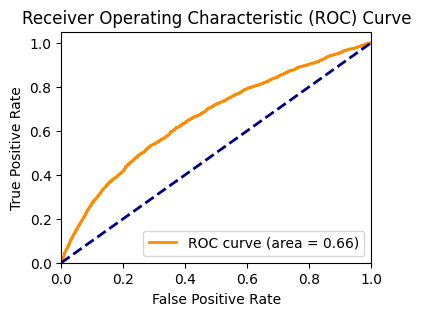



CatBoostClassifier


Confusion matrix : 



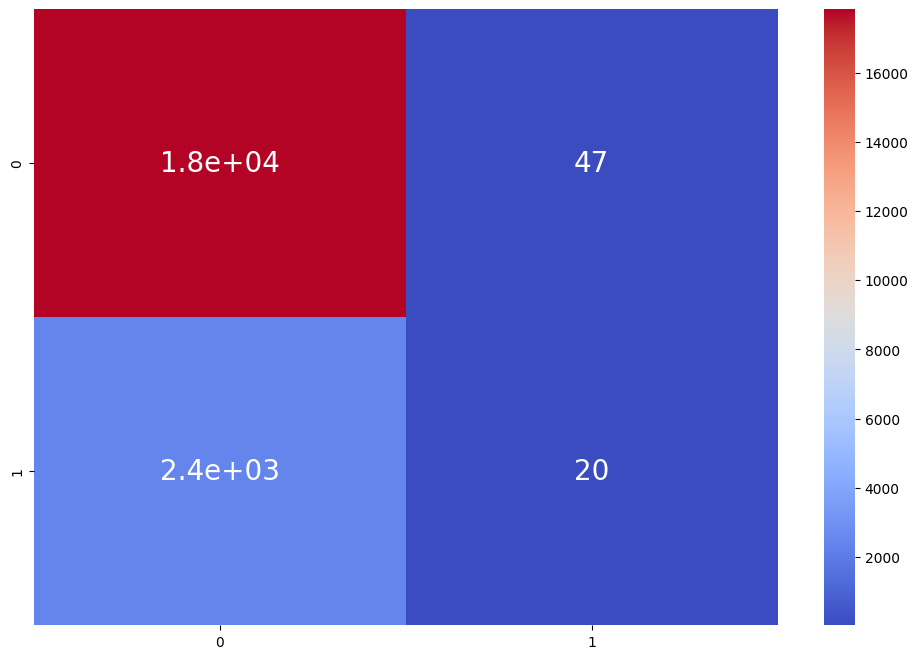



Training score : 0.8875


Test Score : 0.8792


K-fold accuracy : 0.0255


Standard Deviation of Accuracies in k-fold : 0.0044


Classification report : 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     17883
           1       0.30      0.01      0.02      2427

    accuracy                           0.88     20310
   macro avg       0.59      0.50      0.48     20310
weighted avg       0.81      0.88      0.83     20310



F1 Score : 1.6038492381716123


Evaluation Score : 0.3464453354380963







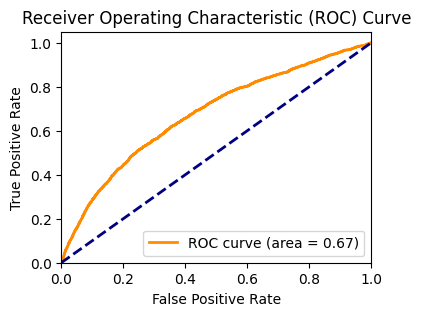



RandomForest


Confusion matrix : 



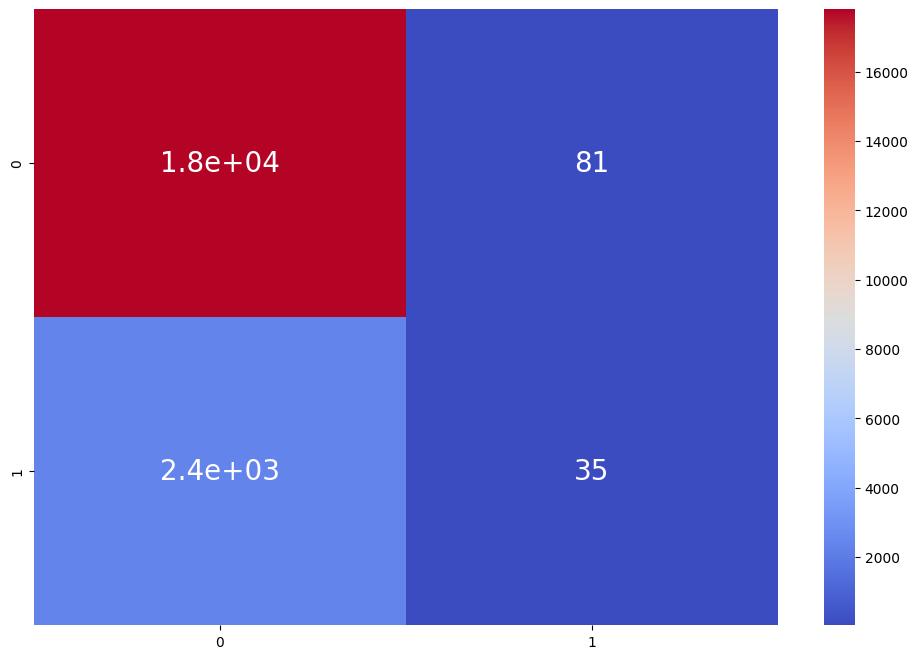



Training score : 0.9998


Test Score : 0.8782


K-fold accuracy : 0.0324


Standard Deviation of Accuracies in k-fold : 0.0084


Classification report : 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     17883
           1       0.30      0.01      0.03      2427

    accuracy                           0.88     20310
   macro avg       0.59      0.50      0.48     20310
weighted avg       0.81      0.88      0.83     20310



F1 Score : 2.7526543452615018


Evaluation Score : 0.37040161329998983







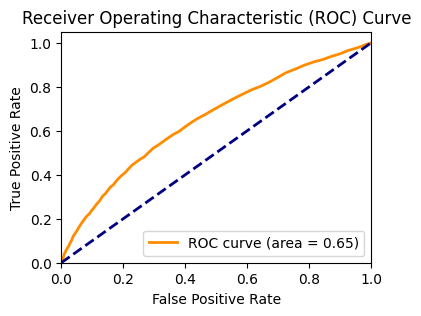



Extra Tree Classifier


Confusion matrix : 



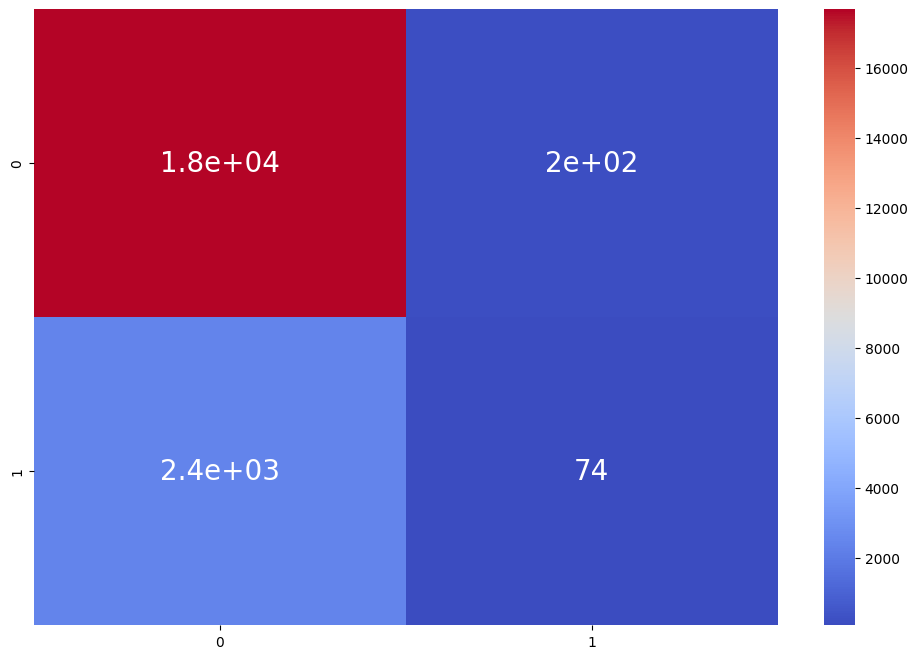



Training score : 0.9998


Test Score : 0.8742


K-fold accuracy : 0.0448


Standard Deviation of Accuracies in k-fold : 0.0096


Classification report : 

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     17883
           1       0.27      0.03      0.05      2427

    accuracy                           0.87     20310
   macro avg       0.58      0.51      0.49     20310
weighted avg       0.81      0.87      0.83     20310



F1 Score : 5.475397706252312


Evaluation Score : 0.44800383868754723







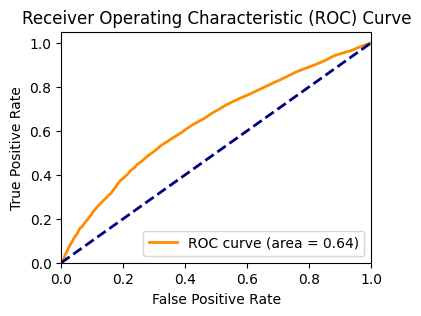



Bagging Classifier


Confusion matrix : 



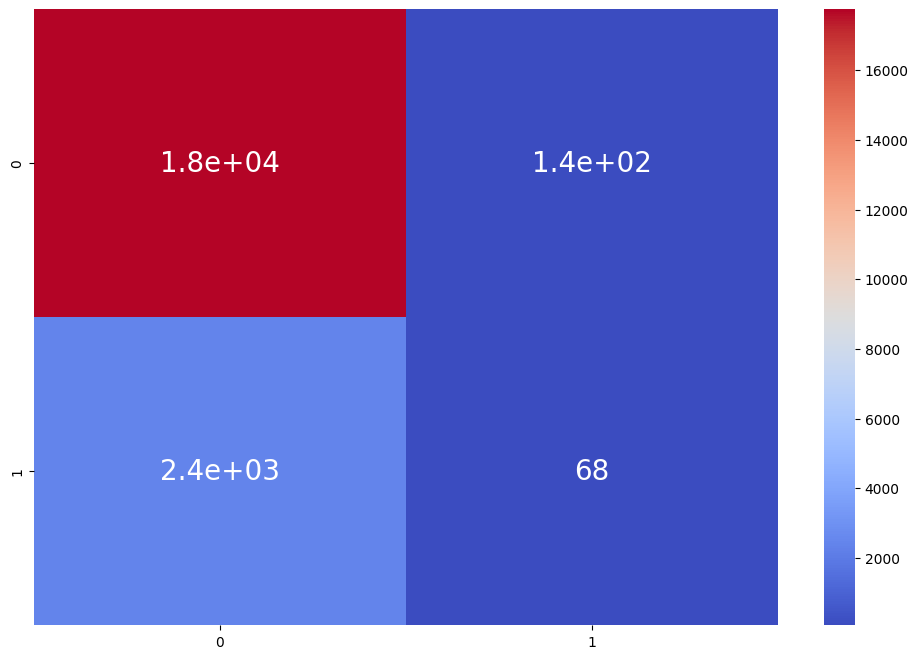



Training score : 0.9998


Test Score : 0.8772


K-fold accuracy : 0.0515


Standard Deviation of Accuracies in k-fold : 0.0107


Classification report : 

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     17883
           1       0.33      0.03      0.05      2427

    accuracy                           0.88     20310
   macro avg       0.61      0.51      0.49     20310
weighted avg       0.82      0.88      0.83     20310



F1 Score : 5.169137210186241


Evaluation Score : 0.37796091149517347







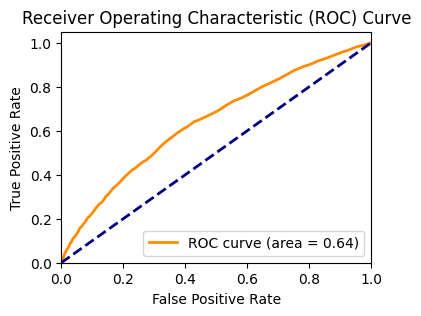



Gradient Boosting Classifier


Confusion matrix : 



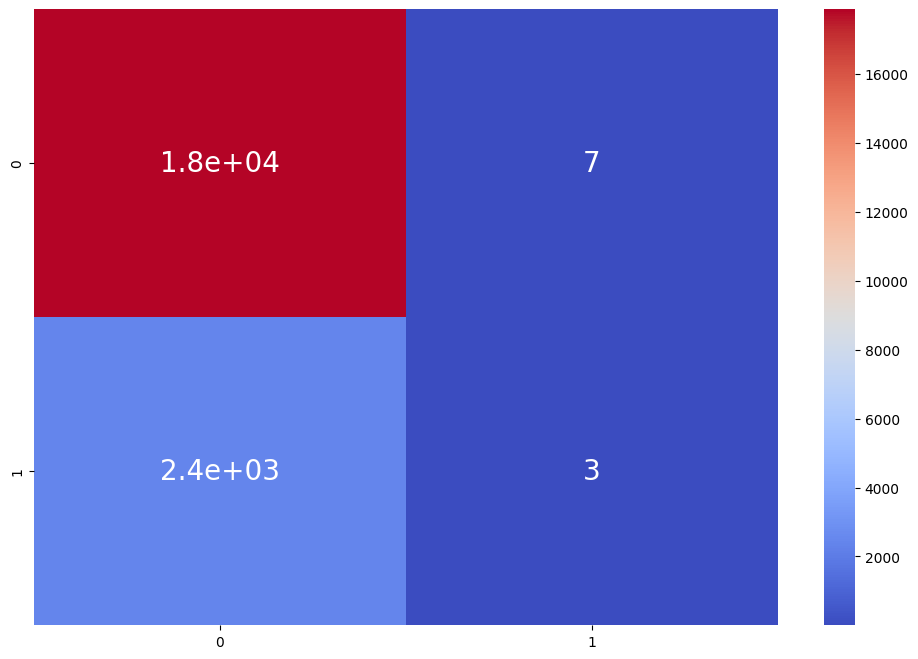



Training score : 0.8796


Test Score : 0.8803


K-fold accuracy : 0.0027


Standard Deviation of Accuracies in k-fold : 0.0017


Classification report : 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     17883
           1       0.30      0.00      0.00      2427

    accuracy                           0.88     20310
   macro avg       0.59      0.50      0.47     20310
weighted avg       0.81      0.88      0.82     20310



F1 Score : 0.24620434961017645


Evaluation Score : 0.3438574969182394







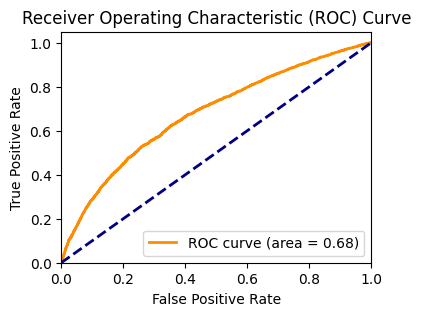

[LightGBM] [Info] Number of positive: 7356, number of negative: 53574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 60930, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120729 -> initscore=-1.985548
[LightGBM] [Info] Start training from score -1.985548
[LightGBM] [Info] Number of positive: 5885, number of negative: 42859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 48744, number of used features: 14
[LightGBM] [Info] [bin

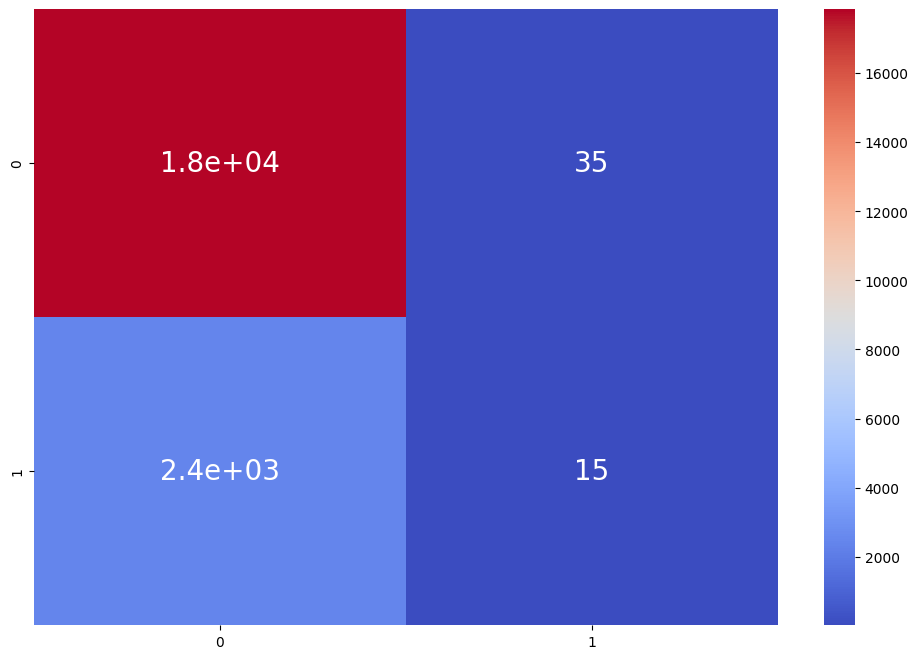



Training score : 0.8836


Test Score : 0.8795


K-fold accuracy : 0.0143


Standard Deviation of Accuracies in k-fold : 0.0035


Classification report : 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     17883
           1       0.30      0.01      0.01      2427

    accuracy                           0.88     20310
   macro avg       0.59      0.50      0.47     20310
weighted avg       0.81      0.88      0.83     20310



F1 Score : 1.2111425111021394


Evaluation Score : 0.3452218905531242







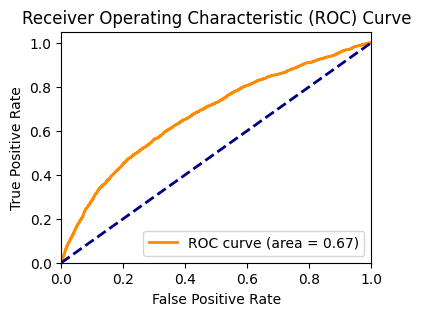



Logistic Regression


Confusion matrix : 



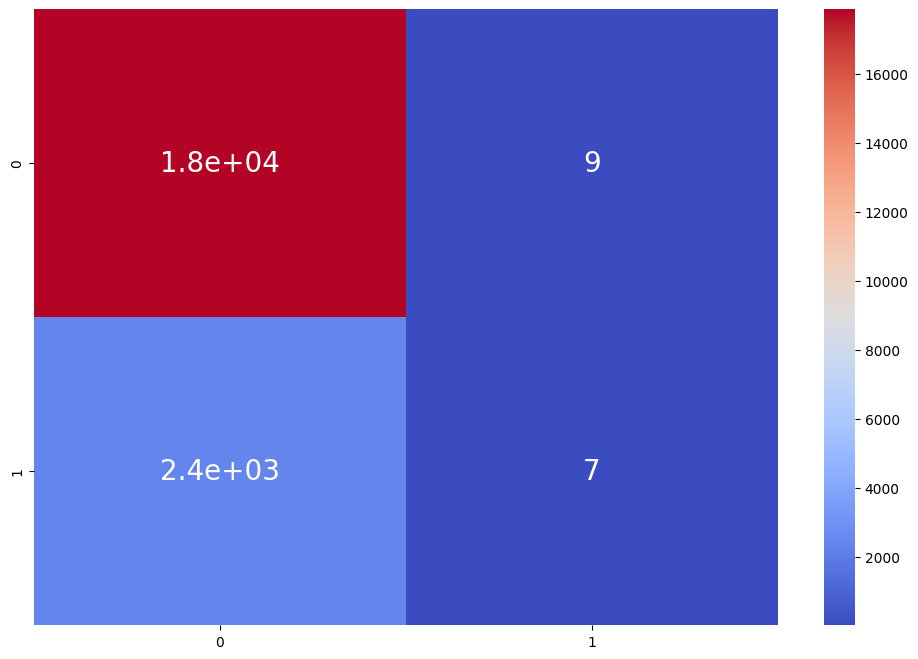



Training score : 0.8792


Test Score : 0.8804


K-fold accuracy : 0.0024


Standard Deviation of Accuracies in k-fold : 0.0010


Classification report : 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     17883
           1       0.44      0.00      0.01      2427

    accuracy                           0.88     20310
   macro avg       0.66      0.50      0.47     20310
weighted avg       0.83      0.88      0.83     20310



F1 Score : 0.5730659025787965


Evaluation Score : 0.3484894435870328







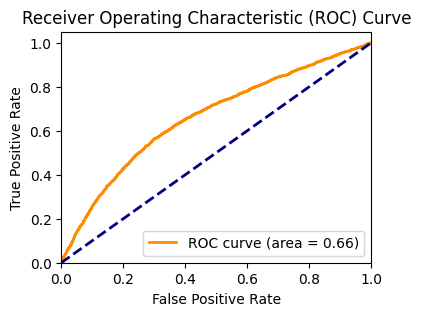



KNeigbors


Confusion matrix : 



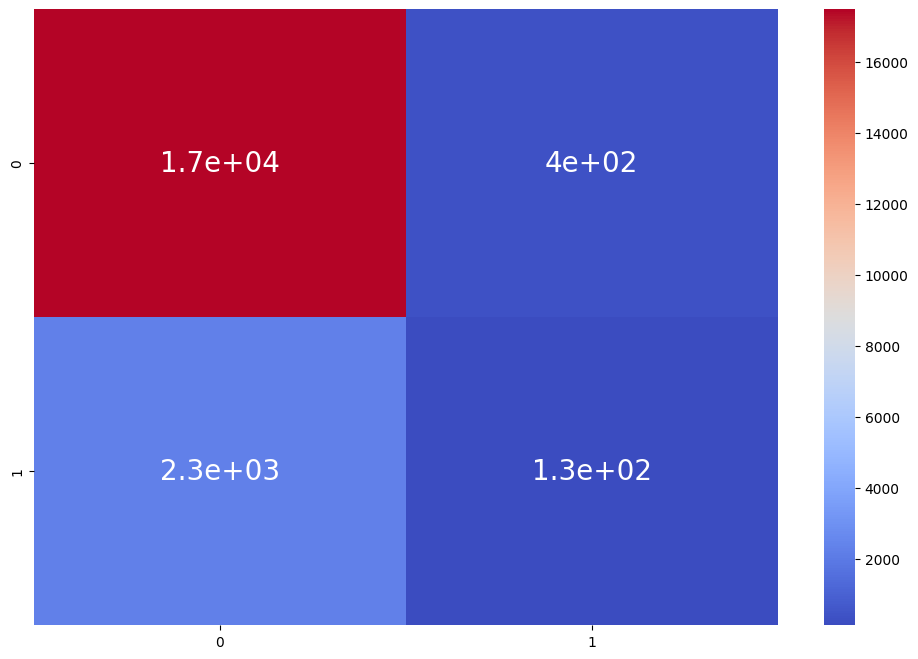



Training score : 0.8872


Test Score : 0.8672


K-fold accuracy : 0.0936


Standard Deviation of Accuracies in k-fold : 0.0045


Classification report : 

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     17883
           1       0.25      0.06      0.09      2427

    accuracy                           0.87     20310
   macro avg       0.57      0.52      0.51     20310
weighted avg       0.81      0.87      0.83     20310



F1 Score : 9.038785834738617


Evaluation Score : 2.15889357305857







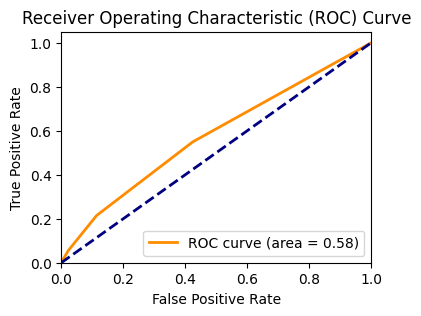

CPU times: total: 16min 22s
Wall time: 21min 41s


In [30]:
%%time

pre_final = []

for i in models:
    sam = evaluation_metrics(i , X_train , y_train , X_test, y_test)
    pre_final.append(sam)